In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import qutip

In [5]:
import nvmodels

In [6]:
import nvmodels.simulations.simple_cwodmr as scw

In [7]:
B_mag = 25e-4
polar = 0
azimuthal = 0
_x = np.sin(polar)*np.cos(azimuthal)
_y = np.sin(polar)*np.sin(azimuthal)
_z = np.cos(polar)
static_B_field = B_mag*np.array([_x, _y, _z])

In [8]:
h_gs, h_es, h_full = scw.hamiltonian(static_B_field)

#### Examine the H_full

This is the full Hamiltonian, including the long-lived inter-system crossing state.

It should be noted that the excited state Hamiltonian does not include the ~470 THz energy difference
relative to the ground state. As such, the excited states will appear in the plot at similar energy scale as
the ground state

In [9]:
h_full

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[ 1.02674587e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.86587468e+08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07167459e+10
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.70666667e+09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.05765875e+10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e+09]]

Text(0.5, 0, 'State index')

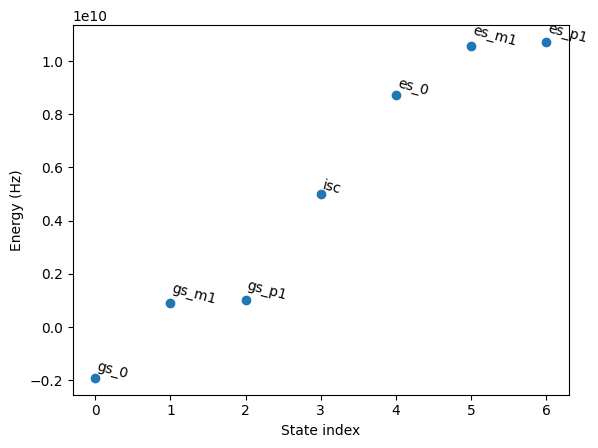

In [10]:
eigenvalues, eigenstates = h_full.eigenstates()

fig, ax = nvmodels.plotting.plot_eigenspectrum_mpl(eigenvalues, scw.state_ids().keys())
ax.set_ylabel('Energy (Hz)')
ax.set_xlabel('State index')

# state labels:
# gs_0 -- ground state, ms=0
# isc -- inter-system crossing
# es_p1 -- excited state, ms=+1
# etc...

# Evolve the system

In [11]:
gamma_optical_pump = scw.build_transfer_rates(h_full, rabi_frequency=0)

In [12]:
qutip.Qobj(gamma_optical_pump) # transfe r rates between states

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = False
Qobj data =
[[0.00000000e+00 3.33175051e+02 3.33175051e+02 0.00000000e+00
  3.30000000e+06 0.00000000e+00 0.00000000e+00]
 [3.33333333e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.30000000e+06 0.00000000e+00]
 [3.33333333e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.30000000e+06]
 [3.46020761e+06 2.15982721e+06 2.15982721e+06 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.32911392e+07 0.00000000e+00 0.00000000e+00 1.30039012e+07
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.28930818e+07 0.00000000e+00 8.00000000e+07
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.28930818e+07 8.00000000e+07
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]

In [13]:
observables = []
observables.append(scw.pl_rate_observable(gamma_optical_pump)) 
observables += [obs for obs in scw.state_population_observables(gamma_optical_pump.shape[0])]

In [40]:
times = np.linspace(0,5e-6,2000)

In [17]:
result_optical_pump = qutip.mesolve(h_full, 
                                    scw.psi0_ground_state(h_full), 
                                    times, 
                                    scw.build_Lindblad_operators(gamma_optical_pump).values(), 
                                    observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

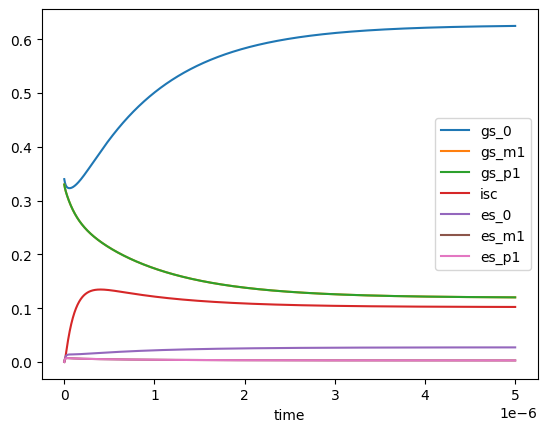

In [18]:
scw.plot_observables(times, result_optical_pump.expect[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

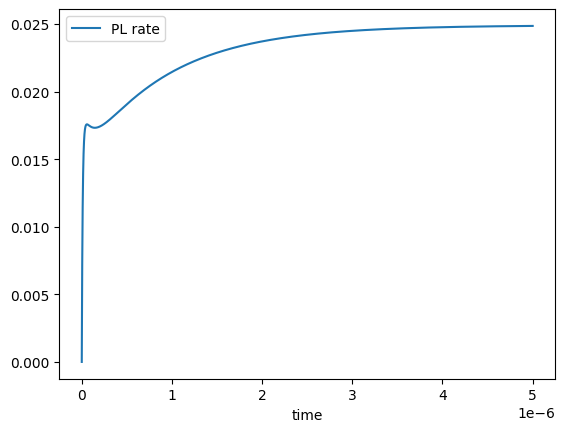

In [19]:
scw.plot_observables(times, result_optical_pump.expect[:1], ['PL rate'])

### Add resonant MW source

In [20]:
gamma_optical_pump_rabi = scw.build_transfer_rates(h_full, rabi_frequency=1e6, rabi_state='gs_m1')

In [30]:
result_optical_pump_rabi = qutip.mesolve(h_full, 
                                         scw.psi0_from_results(result_optical_pump.expect[1:]), 
                                         times, 
                                         scw.build_Lindblad_operators(gamma_optical_pump_rabi).values(), 
                                         observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

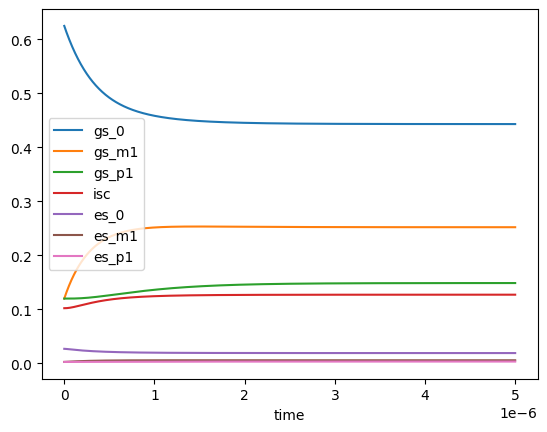

In [31]:
scw.plot_observables(times, result_optical_pump_rabi.expect[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

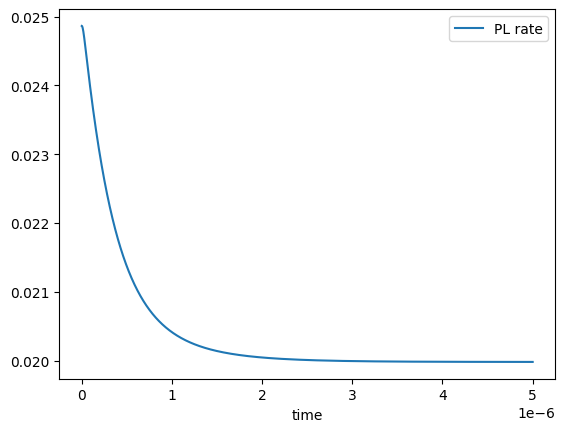

In [58]:
scw.plot_observables(times, result_optical_pump_rabi.expect[:1], ['PL rate'])

In [55]:
# let's do one more full cycle

In [56]:
result_optical_pump_c2 = qutip.mesolve(h_full, 
                                       scw.psi0_from_results(result_optical_pump_rabi.expect[1:]), 
                                       times, 
                                       scw.build_Lindblad_operators(gamma_optical_pump).values(), 
                                       observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

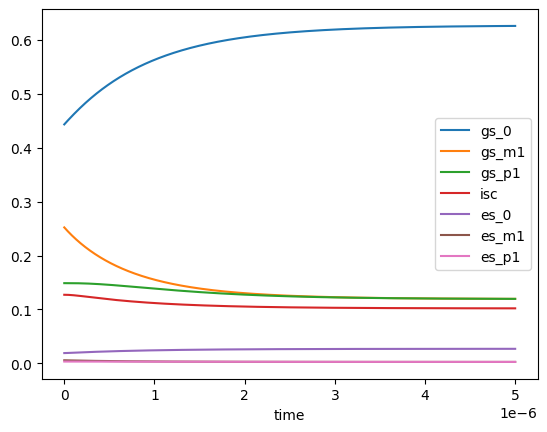

In [57]:
scw.plot_observables(times, result_optical_pump_c2.expect[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

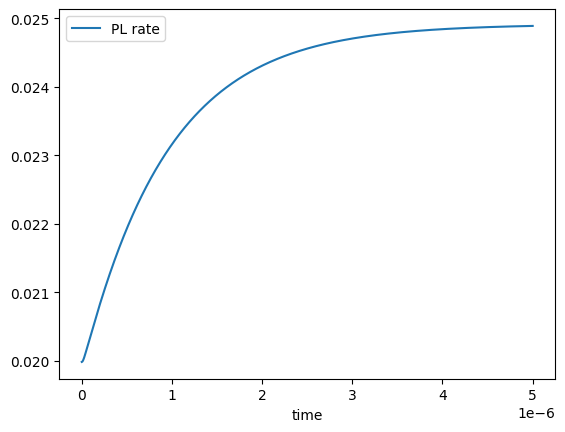

In [59]:
scw.plot_observables(times, result_optical_pump_c2.expect[:1], ['PL rate'])

In [60]:
result_optical_pump_rabi_c2 = qutip.mesolve(h_full, 
                                         scw.psi0_from_results(result_optical_pump_c2.expect[1:]), 
                                         times, 
                                         scw.build_Lindblad_operators(gamma_optical_pump_rabi).values(), 
                                         observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

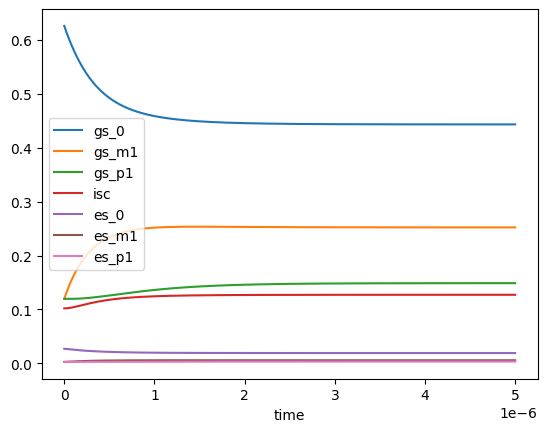

In [61]:
scw.plot_observables(times, result_optical_pump_rabi_c2.expect[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

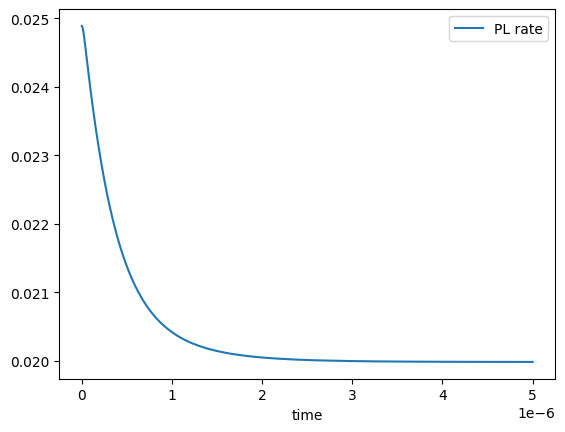

In [62]:
scw.plot_observables(times, result_optical_pump_rabi_c2.expect[:1], ['PL rate'])

In [ ]:
# append the results to look at a full sequence

In [63]:
full_times = np.hstack((times, times[-1] + times, 2*times[-1] + times, 3*times[-1] + times))

In [66]:
full_observables = np.hstack( (result_optical_pump.expect,
                              result_optical_pump_rabi.expect,
                               result_optical_pump_c2.expect,
                              result_optical_pump_rabi_c2.expect,))

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

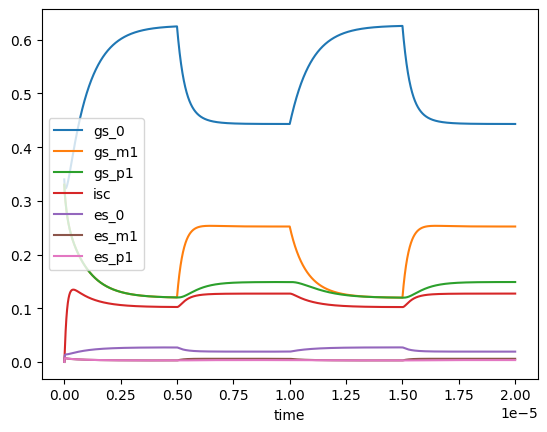

In [67]:
scw.plot_observables(full_times, full_observables[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

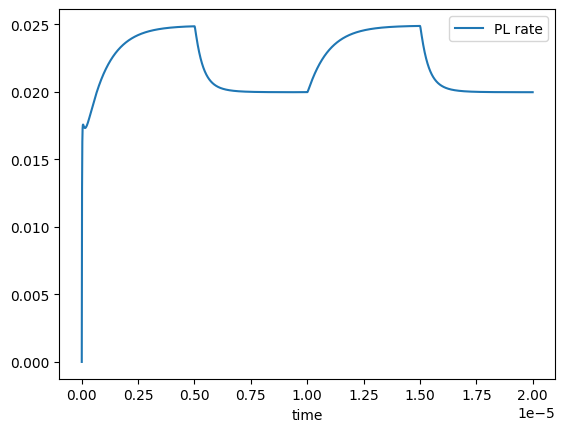

In [70]:
scw.plot_observables(full_times, full_observables[:1], ['PL rate'])

In [71]:
#let's turn off the lights and MW and see the results
gamma_off = scw.build_transfer_rates(h_full, optical_pumping_watts=0, rabi_frequency=0)

In [74]:
result_all_off = qutip.mesolve(h_full, 
                               scw.psi0_from_results(result_optical_pump_rabi_c2.expect[1:]), 
                               times, 
                               scw.build_Lindblad_operators(gamma_off).values(), 
                               observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

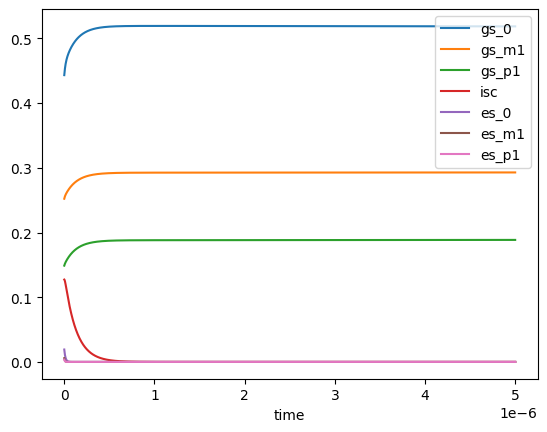

In [76]:
scw.plot_observables(times, result_all_off.expect[1:], scw.state_ids().keys())

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

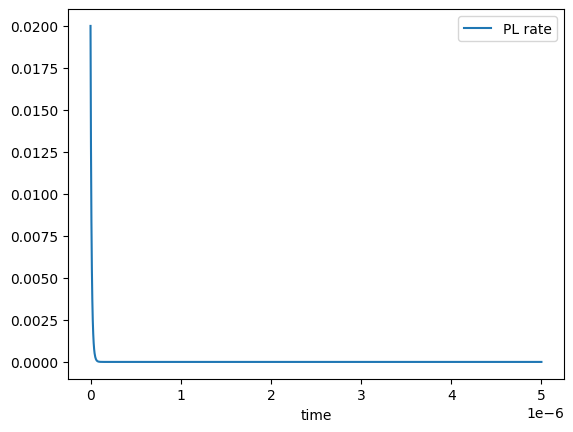

In [78]:
scw.plot_observables(times, result_all_off.expect[:1], ['PL rate'])

In [79]:
long_time = np.linspace(0,6e-3,2000)

result_all_off = qutip.mesolve(h_full, 
                               scw.psi0_from_results(result_optical_pump_rabi_c2.expect[1:]), 
                               long_time, 
                               scw.build_Lindblad_operators(gamma_off).values(), 
                               observables)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time'>)

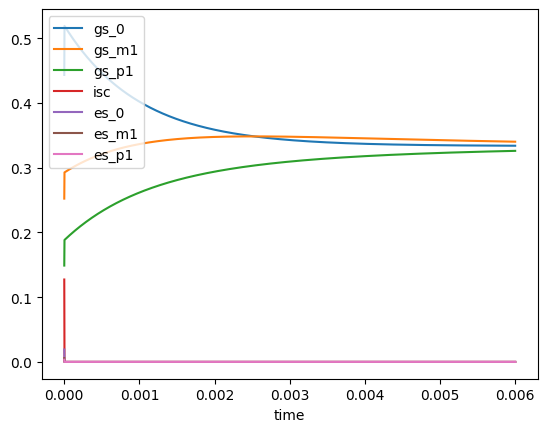

In [81]:
scw.plot_observables(long_time, result_all_off.expect[1:], scw.state_ids().keys())